<a href="https://colab.research.google.com/github/Pusse-01/Face-Mask-Detector/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries and Preprocessing


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import tensorflow as tf
import keras
import cv2
import os
import numpy as np
from keras.utils import np_utils
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint




In [3]:
data_path= '/content/drive/MyDrive/Face mask detector/dataset'

In [4]:
categories=os.listdir(data_path)
labels=[i for i in range (len(categories))]
label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without mask': 0, 'with mask': 1}
['without mask', 'with mask']
[0, 1]


In [5]:
img_size=100
data=[]
target=[]


In [6]:
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
          gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
          resized=cv2.resize(gray,(img_size,img_size))
          data.append(resized)
          target.append(label_dict[category])
          
        except Exception as e:
          print('Exception:',e)


In [7]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

In [8]:
np.save('data',data)
np.save('target',new_target)

Training the Model

In [9]:
data=np.load('data.npy')
target=np.load('target.npy')

In [13]:
model = keras.models.Sequential([keras.layers.Conv2D(200,(3,3),activation = 'relu',input_shape=data.shape[1:]),
                                   keras.layers.MaxPool2D(2,2),
                                   #
                                   keras.layers.Conv2D(100,(3,3),activation = 'relu'),
                                   keras.layers.MaxPool2D(2,2),
                                   #
                                   keras.layers.Flatten(),
                                   keras.layers.Dropout(0.5),
                                   ##
                                   keras.layers.Dense(50,activation='relu'),
                                   ##
                                   keras.layers.Dense(2,activation='softmax'),
                                   ])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [14]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [24]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Face mask detector/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
31/31 [==============================] - 3s 89ms/step - loss: 0.0260 - accuracy: 0.9899 - val_loss: 0.2637 - val_accuracy: 0.9395
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Face mask detector/model-001.model/assets
Epoch 2/20
31/31 [==============================] - 3s 85ms/step - loss: 0.0228 - accuracy: 0.9899 - val_loss: 0.2748 - val_accuracy: 0.9476
Epoch 3/20
31/31 [==============================] - 3s 85ms/step - loss: 0.0125 - accuracy: 0.9939 - val_loss: 0.2787 - val_accuracy: 0.9516
Epoch 4/20
31/31 [==============================] - 3s 85ms/step - loss: 0.0125 - accuracy: 0.9949 - val_loss: 0.2420 - val_accuracy: 0.9516
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Face mask detector/model-004.model/assets
Epoch 5/20
31/31 [==============================] - 3s 85ms/step - loss: 0.0138 - accuracy: 0.9949 - val_loss: 0.2735 - val_accuracy: 0.9476
Epoch 6/20
31/31 [==============================] - 3s 85ms/step - loss: 0.0227 - accuracy: 0.9

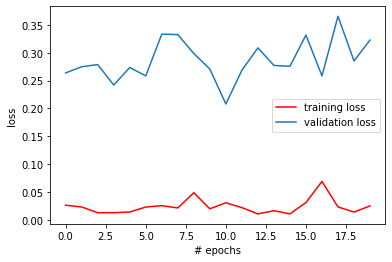

In [25]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

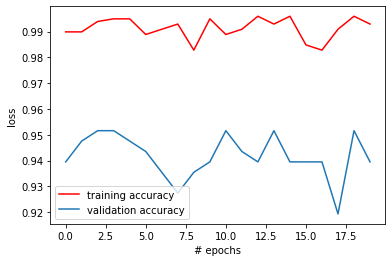

In [26]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [30]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Face mask detector/model-017.model')

face_clsfr=cv2.CascadeClassifier('/content/drive/MyDrive/Face mask detector/haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [28]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

error: ignored